Run this notebook to approximate shortest time to exit from a domain

In [43]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float64)
import random

import json

from IPython.display import display, Math, Markdown

import datetime
import os
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
timestamp
version = '_0.1.0'
import math
pi = math.pi

torch.autograd.set_detect_anomaly(True) #Helps with finding inplaced variables in torch

# Shortest exit time

Given a bounded domain $D\subset\mathbb{R}^d$, find 

$\inf_{u}\{t\ge0~:~x_t\not\in D\}$

where ${dx}_t=u_t{{dt}}$ with control $|u_t|\le1$ and $u_t\in\mathbb{R}^d$ and initial position $x_0=x\in D$.


For  $D=[a,b]\subset\mathbb{R}$, the solution is obvious; go full speed to the nearest exit point $a$ or $b$. In higher dimension, the solution is not as simple. 

Here, we use a specific cost function to approximately find the solution of this problem.

# Approximation of velocity with neural networks

## Defining a neural network in torch

In [ ]:
num_neurons = 40
velocity= torch.nn.Sequential(
            torch.nn.Linear(1, num_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(num_neurons, num_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(num_neurons,1),
        )

## Generate samples for the initial point $x_0$

This helps up solve the problem for the whole interval $[a,b]$ once for all.


In [45]:
M = 10 # number of samples for x0
a = 0 #interval start
b = 1 #interval end
x0 = a + torch.rand([M,1])*(b-a)
T = 1. # time horizon (artificial)
N = 20 # number of time steps
delta = T/N # time step

## Dynamic of the state process

In [68]:
def state(x0,model,**kwargs):
    m = kwargs.get('num_samples',M)
    t = torch.linspace(0, T, N+1)
    x = torch.zeros((m, N+1, 1))
    x[:,0,:] = x0
    tmp = x[:,0,:].clone().detach()# If we do not do .clone().detach(), what goes wrong? 
    target_ind = torch.nn.ReLU()(tmp-a) - 2*torch.nn.ReLU()(tmp-(a+b)/2) + torch.nn.ReLU()(tmp-b) # Why do we define the target_ind
    for n in range (1, N+1):
        x[:,n,:] = tmp + torch.minimum(torch.maximum(model(tmp),torch.tensor([-1.]*m).reshape(M,1)),torch.tensor([1.]*m).reshape(m,1)) *delta * target_ind
        tmp = x[:,0,:].clone().detach() # If we do not do .clone().detach(), what goes wrong? 
        target_ind = torch.nn.ReLU()(tmp-a) - 2*torch.nn.ReLU()(tmp-(a+b)/2) + torch.nn.ReLU()(tmp-b)
    return x

## Loss function

Loss function for the problem is the combination of running cost and the terminal function. For this problem:

$C(x,u)=1\!\!1_{\{x\in[a,b]\}}$ and $g(x)=1\!\!1_{\{x\in[a,b]\}}$

In [ ]:
def loss(x):
    loss_ = (x[:,N,:]>a).float()*(x[:,N,:]<b).float() + torch.nn.ReLU()(x[:,N,:]) - torch.nn.ReLU()(x[:,N,:])#to make auto-differentiation work. require gradient
    # print(loss_.requires_grad)
    for n in range(0,N):
        loss_ = loss_ + (x[:,n,:]>a).float()*(x[:,n,:]<b).float()*delta #+ torch.nn.ReLU()(x[:,n,:]) - torch.nn.ReLU()(x[:,n,:]) 
        # print(loss_.requires_grad)
    return loss_
    

## Training

In [48]:
# plt.plot(torch.linspace(0, T, N+1),x[2,:,0].clone().detach().numpy())
# plt.plot(torch.linspace(0, T, N+1),x[0,:,0].clone().detach().numpy(), marker='o')

In [ ]:
num_epochs = 1000
learning_rate = 1e-1
# optimizer = optim.Adam(velocity.parameters(), learning_rate)
for e in range(num_epochs):
    x = state(x0,velocity)
    loss_ = loss(x)
    cost = torch.mean(loss_)
    # optimizer.zero_grad() # Zero the gradients before running the backward pass.
    velocity.zero_grad() # Zero the gradients before running the backward pass.    
    cost.backward() # Backward pass: compute gradient of the loss with respect to all the learnable parameters
    if e % 100 == 0:
        print(e+1, cost)
    with torch.no_grad(): # Update the weights using gradient descent. Each parameter is a Tensor, so
        for param in velocity.parameters(): # We can access its gradients like we did before.
            param -= learning_rate * param.grad # Update the weights using gradient descent
    # optimizer.step() # Update the weights using gradient descent. Each parameter is a Tensor, so

1 tensor(2.0000, grad_fn=<MeanBackward0>)
101 tensor(2.0000, grad_fn=<MeanBackward0>)
201 tensor(2.0000, grad_fn=<MeanBackward0>)
301 tensor(2.0000, grad_fn=<MeanBackward0>)
401 tensor(2.0000, grad_fn=<MeanBackward0>)
501 tensor(2.0000, grad_fn=<MeanBackward0>)
601 tensor(2.0000, grad_fn=<MeanBackward0>)
701 tensor(2.0000, grad_fn=<MeanBackward0>)
801 tensor(2.0000, grad_fn=<MeanBackward0>)
901 tensor(2.0000, grad_fn=<MeanBackward0>)


The loss function does not change and the model is not properly trained. Why?

# Reimplementation of the problem with different cost functions

## New cost functions

Write the formula for the cost functions defined below.

In [72]:
def new_loss(x):
    loss_ = torch.nn.ReLU()(x[:,N,:]-a) - 2*torch.nn.ReLU()(x[:,N,:]-(a+b)/2) + torch.nn.ReLU()(x[:,N,:]-b)
    # print(loss_.requires_grad)
    for n in range(0,N):
        loss_ = loss_ + (torch.nn.ReLU()(x[:,n,:]-a) - 2*torch.nn.ReLU()(x[:,n,:]-(a+b)/2) + torch.nn.ReLU()(x[:,n,:]-b))*delta 
        # print(loss_.requires_grad)
    return loss_

In [ ]:
torch.autograd.set_detect_anomaly(True)
num_epochs = 3000
learning_rate = 1e-1
# optimizer = optim.Adam(velocity.parameters(), learning_rate)
for e in range(num_epochs):
    x = state(x0,velocity)
    loss_ = new_loss(x)
    cost = torch.mean(loss_)
    # optimizer.zero_grad() # Zero the gradients before running the backward pass.
    velocity.zero_grad() # Zero the gradients before running the backward pass.    
    cost.backward() # Backward pass: compute gradient of the loss with respect to all the learnable parameters
    if e % 500 == 0:
        print(e+1, cost)
    with torch.no_grad(): # Update the weights using gradient descent. Each parameter is a Tensor, so
        for param in velocity.parameters(): # We can access its gradients like we did before.
            param -= learning_rate * param.grad # Update the weights using gradient descent
    # optimizer.step() # Update the weights using gradient descent. Each parameter is a Tensor, so

1 tensor(0.3770, grad_fn=<MeanBackward0>)
501 tensor(0.3723, grad_fn=<MeanBackward0>)
1001 tensor(0.3707, grad_fn=<MeanBackward0>)
1501 tensor(0.3707, grad_fn=<MeanBackward0>)
2001 tensor(0.3707, grad_fn=<MeanBackward0>)
2501 tensor(0.3707, grad_fn=<MeanBackward0>)


Plot below shows the approximate optimal velocity to exit the domain. 

    . Increase the number of time-steps and rerun the code to see if the approximation gets more accurate.

    . Increase the magnitude of the new loss function to see how the result is changed.

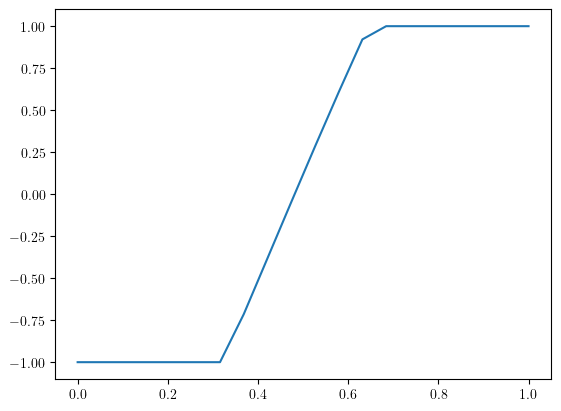

In [55]:
x1 = torch.linspace(a,b,N).unsqueeze(-1).unsqueeze(0)
plt.plot(x1[0,:,0].clone().detach().numpy(),torch.minimum(torch.maximum(velocity(x1),torch.tensor([-1.])),torch.tensor([1.]))[0,:,0].clone().detach().numpy());

torch.Size([10, 21, 1])


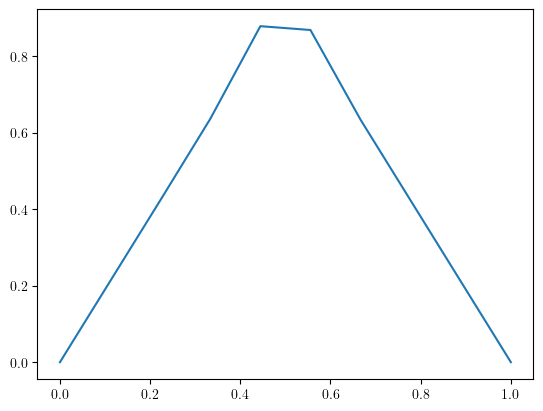

In [ ]:
x1 = torch.linspace(a,b,M).unsqueeze(-1)
x2 = state(x1,velocity,num_samples=M)
l = new_loss(x2)
plt.plot(x1[:,0].clone().detach().numpy(),l.clone().detach().numpy());